# Make cosmosis

In [19]:
%matplotlib inline
import sys
import copy
sys.path.insert(0, '/global/homes/m/mgatti/clustering-z/WZ_utils/')
from covariance_routines import *
from load_routines import *
import matplotlib.pyplot as plt
import numpy
import h5py
import pyfits as pf
from scipy.interpolate import UnivariateSpline
import twopoint
from routines import *

def rebin(z_old, pdf_old, zbins):
        # spline
        kwargs_spline = {'s': 0,  # force spline to go through data points
                         'ext': 'zeros',  # ext=0 means extrapolate, =1 means return 0
                         'k': 3,
                        }
        spline = UnivariateSpline(z_old, pdf_old, **kwargs_spline)
        pdf = np.zeros(len(zbins) - 1)
        for i in range(len(zbins) - 1):
            zmin = zbins[i]
            zmax = zbins[i + 1]
            pdf[i] = spline.integral(zmin, zmax) #/ (zmax - zmin)
        return pdf

    

In [6]:
template = pf.open(path_sompz_data)
template[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   56 / length of dimension 1                          
NAXIS2  =                  300 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'Z_LOW   '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'Z_MID   '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z_HIGH  '        

In [7]:
mute = pf.open(path_sompz_sims)
mute[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   56 / length of dimension 1                          
NAXIS2  =                  300 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'Z_LOW   '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'Z_MID   '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z_HIGH  '        

In [10]:

    
    
    
# files: **************************************
path_sompz_data = '/global/cscratch1/sd/aamon/sompz_data/v0.40/y3_redshift_distributions_v0.40_modal_even_bincond_pileup3.fits'
path_sompz_sims = '/global/cscratch1/sd/jmyles/sompz_buzzard/v0.25/y3_redshift_distributions_v0.25_modal_even_bincond_pileup3.fits'
mastercat_v = '03_31_20'
path_mastercat_data = '/project/projectdirs/des/www/y3_cats/Y3_mastercat_'+mastercat_v+'.h5'
path_mastercat_sims = '/global/project/projectdirs/des/jderose/Chinchilla/Herd/Chinchilla-3/v2.0.0/sampleselection/Y3a/Buzzard-3_v2.0_Y3a_mastercat.h5'
#path= '/global/project/projectdirs/des/jderose/Chinchilla/Herd/Chinchilla-3/v1.9.8/sampleselection/Y3a/mastercat/'
version = 'v2.0_Y3a'




# eboss setup *********************************
zmin=0.1
zmax=1.1
eboss_bins= 15
bins_eboss = np.linspace(zmin,zmax,eboss_bins+1)


#redmagic setup *******************************
zmin=0.15
zmax=0.95
rm_bins= 25
bins_rm = np.linspace(zmin,zmax,rm_bins+1)


# high resolution grid (for cosmosis) *********
hrn = 301
bins_hr = np.linspace(0.,2.25,hrn)


# wl sample bins **********
bins_wl = [-0.5,0.5,1.5,2.5,3.5]


wl_sims_nz = dict()
wl_data_nz = dict()

# ********************************************************
# read eboss sims & data *********************************
# ********************************************************

folder = "/global/cscratch1/sd/mgatti/clustering_z/data/"
mute = pf.open(folder + 'Buzzard_v2.0_Y3a_eboss_ref_WL_ebosscut_w_Y3.fits')
zspec_tot= np.array(mute[1].data['z'])

Nz =[]
for i in range(eboss_bins):
    mask_z = (zspec_tot>bins_eboss[i]) & (zspec_tot<bins_eboss[i+1] )
    nzrm,edge = np.histogram(zspec_tot[mask_z], bins = bins_hr,normed=True)
    Nz.append(nzrm)
    
name = "nz_lens"
nz_lenses_eboss  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz) 

folder = "/global/cscratch1/sd/mgatti/clustering_z/data/"
mute = pf.open(folder + 'eboss_03_31_20.fits')
zspec_tot= np.array(mute[1].data['z'])

Nz =[]
for i in range(eboss_bins):
    mask_z = (zspec_tot>bins_eboss[i]) & (zspec_tot<bins_eboss[i+1] )
    nzrm,edge = np.histogram(zspec_tot[mask_z], bins = bins_hr,normed=True)
    Nz.append(nzrm)
    
name = "nz_lens"
nz_lenses_eboss_data  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz) 


# ********************************************************
# read rmg  data *********************************
# ********************************************************

mastercat_data = h5py.File(path_mastercat_data ,'r')
zspec_mstf = np.array(mastercat_data['catalog']['redmagic']['combined_sample_fid']['zspec'])
zrmg_mstf = np.array(mastercat_data['catalog']['redmagic']['combined_sample_fid']['zredmagic'])
zspec_smp = np.array(mastercat_data['catalog']['redmagic']['combined_sample_fid']['zredmagic_samp'].value[:,0])


zredmagic_tot= copy.copy(zrmg_mstf)
zspec_tot = copy.copy(zspec_smp)
Nz =[]
for i in range(rm_bins):
    mask_z = (zredmagic_tot>bins_rm[i]) & (zredmagic_tot<bins_rm[i+1] )
    nzrm,edge = np.histogram(zspec_tot[mask_z], bins = bins_hr,normed=True)
    Nz.append(nzrm)
    
name = "nz_lens"
nz_lenses_rm_combined_data2  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz) 


zredmagic_tot= (zrmg_mstf[zspec_mstf>-1])
zspec_tot = (zspec_mstf[zspec_mstf>-1])
Nz =[]
for i in range(rm_bins):
    mask_z = (zredmagic_tot>bins_rm[i]) & (zredmagic_tot<bins_rm[i+1] )
    nzrm,edge = np.histogram(zspec_tot[mask_z], bins = bins_hr,normed=True)
    Nz.append(nzrm)
    
name = "nz_lens"
nz_lenses_rm_combined_data  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz) 

zspec_mstf = np.array(mastercat_data['catalog']['redmagic']['higherlum']['zspec'])
zrmg_mstf = np.array(mastercat_data['catalog']['redmagic']['higherlum']['zredmagic'])
zspec_smp = np.array(mastercat_data['catalog']['redmagic']['higherlum']['zredmagic_samp'].value[:,0])


zredmagic_tot= copy.copy(zrmg_mstf)
zspec_tot = copy.copy(zspec_smp)
Nz =[]
for i in range(rm_bins):
    mask_z = (zredmagic_tot>bins_rm[i]) & (zredmagic_tot<bins_rm[i+1] )
    nzrm,edge = np.histogram(zspec_tot[mask_z], bins = bins_hr,normed=True)
    Nz.append(nzrm)
    
name = "nz_lens"
nz_lenses_rm_data2  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz) 


zredmagic_tot= (zrmg_mstf[zspec_mstf>-1])
zspec_tot = (zspec_mstf[zspec_mstf>-1])
Nz =[]
for i in range(rm_bins):
    mask_z = (zredmagic_tot>bins_rm[i]) & (zredmagic_tot<bins_rm[i+1] )
    nzrm,edge = np.histogram(zspec_tot[mask_z], bins = bins_hr,normed=True)
    Nz.append(nzrm)
    
name = "nz_lens"
nz_lenses_rm_data  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz) 



# ********************************************************
# read rmg  buzzard *********************************
# ********************************************************

mastercat = h5py.File(path_mastercat_sims,'r')
zredmagic_tot = np.array(mastercat['catalog']['redmagic']['combined_sample_fid']['zredmagic'])
zspec_tot = np.array(mastercat['catalog']['redmagic']['combined_sample_fid']['zspec'])

Nz =[]
for i in range(rm_bins):
    mask_z = (zspec_tot>bins_rm[i]) & (zspec_tot<bins_rm[i+1] )
    nzrm,edge = np.histogram(zspec_tot[mask_z], bins = bins_hr,normed=True)
    Nz.append(nzrm)
    
name = "nz_lens"
nz_lenses_combined  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz) 



Nz =[]
for i in range(rm_bins):
    mask_z = (zredmagic_tot>bins_rm[i]) & (zredmagic_tot<bins_rm[i+1] )
    nzrm,edge = np.histogram(zspec_tot[mask_z], bins = bins_hr,normed=True)
    Nz.append(nzrm)
    
name = "nz_lens"
nz_lenses_rm_combined  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz) 



zredmagic_tot = np.array(mastercat['catalog']['redmagic']['higherlum']['zredmagic'])
zspec_tot = np.array(mastercat['catalog']['redmagic']['higherlum']['zspec'])
mastercat.close()

Nz =[]
for i in range(rm_bins):
    mask_z = (zspec_tot>bins_rm[i]) & (zspec_tot<bins_rm[i+1] )
    nzrm,edge = np.histogram(zspec_tot[mask_z], bins = bins_hr,normed=True)
    Nz.append(nzrm)
    
name = "nz_lens"
nz_lenses  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz) 

Nz =[]
for i in range(rm_bins):
    mask_z = (zredmagic_tot>bins_rm[i]) & (zredmagic_tot<bins_rm[i+1] )
    nzrm,edge = np.histogram(zspec_tot[mask_z], bins = bins_hr,normed=True)
    Nz.append(nzrm)
    
name = "nz_lens"
nz_lenses_rm  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz) 





# ********************************************************
# read sompz data *********************************
# ********************************************************

template = pf.open(path_sompz_data)
nz_sompz = pd.DataFrame(template[1].data)


Nz=[]
for i in range(4):
    nzm = rebin(nz_sompz['Z_MID'], nz_sompz['BIN{0}'.format(i+1)], bins_hr)
    nzm = nzm*1./np.sum(nzm)*(bins_hr[1]-bins_hr[0]) #normalis.
    Nz.append(nzm)
    wl_data_nz[i] = {'z':(edge[:-1]+edge[1:])/2.,'Nz':nzm}
Nz_eb=copy.copy(Nz)
Nz.append(np.ones((rm_bins)))
Nz_eb.append(np.ones((eboss_bins)))
name = "nz_source"
nz_wl_data  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz)
nz_wl_data_eb  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz_eb)




# ********************************************************
# read sompz sims *********************************
# ********************************************************

mute = pf.open(path_sompz_sims)
nz_sompz_sims = pd.DataFrame(mute[1].data)
# redshift_pz = mute[1].data["z"]

Nz=[]
for i in range(4):
#     mask_z = (meanz_pz>bins_wl[i]) & (meanz_pz<bins_wl[i+1] )
#     nzrm,edge = np.histogram(redshift_pz[mask_z], bins = bins_hr)
    nzm = rebin(nz_sompz_sims['Z_MID'], nz_sompz_sims['BIN{0}'.format(i+1)], bins_hr)

    nzrm = nzm*1./np.sum(nzm)*(bins_hr[1]-bins_hr[0])
    wl_sims_nz[i] = {'z':(edge[:-1]+edge[1:])/2.,'Nz':nzrm}
    Nz.append(nzrm)
Nz_eb=copy.copy(Nz)
Nz.append(np.ones((rm_bins)))
Nz_eb.append(np.ones((eboss_bins)))
name = "nz_source"
nz_wl_sims  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz)
nz_wl_sims_eb  = twopoint.NumberDensity(name, edge[:-1], (edge[:-1]+edge[1:])/2., edge[1:], Nz_eb)

mastercat.close()







# ********************************************************
# SAVE *********************************
# ********************************************************


path_cosmosis ='/global/homes/g/giannini/clustering-z/cosmosis/mcat_03_31_20'



name = path_cosmosis+"/sims_WL_eboss.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_sims_eb,nz_lenses_eboss)
obj1.to_fits(name)


name = path_cosmosis+"/data_WL_eboss.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_data_eb,nz_lenses_eboss_data)
obj1.to_fits(name)





name = path_cosmosis+"/sims_WL_rmg_truez.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_sims,nz_lenses)
obj1.to_fits(name)


name = path_cosmosis+"/sims_WL_rmg_rmgz_combined.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_sims,nz_lenses_rm_combined)
obj1.to_fits(name)



name = path_cosmosis+"/sims_WL_rmg_rmgz_combined_data.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_sims,nz_lenses_rm_combined_data)
obj1.to_fits(name)


name = path_cosmosis+"/sims_WL_rmg_rmgz_higherlum.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_sims,nz_lenses_rm)
obj1.to_fits(name)

name = path_cosmosis+"/sims_WL_rmg_rmgz_higherlum_data.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_sims,nz_lenses_rm_data)
obj1.to_fits(name)

name = path_cosmosis+"/data_WL_rmg_truez.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_data,nz_lenses)
obj1.to_fits(name)


name = path_cosmosis+"/data_WL_rmg_rmgz_higherlum.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_data,nz_lenses_rm)
obj1.to_fits(name)


name = path_cosmosis+"/data_WL_rmg_rmgz_combined.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_data,nz_lenses_rm_combined)
obj1.to_fits(name)


name = path_cosmosis+"/data_WL_rmg_rmgz_higherlum_data.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_data,nz_lenses_rm_data)
obj1.to_fits(name)

name = path_cosmosis+"/data_WL_rmg_rmgz_higherlum_data2.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_data,nz_lenses_rm_data2)
obj1.to_fits(name)



name = path_cosmosis+"/data_WL_rmg_rmgz_combined_data.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_data,nz_lenses_rm_combined_data)
obj1.to_fits(name)

name = path_cosmosis+"/data_WL_rmg_rmgz_combined_data2.fits"
try:
    os.remove(name)
except:
    pass
obj1,a,_ = make_cosmosis_fits_clusteringz(nz_wl_data,nz_lenses_rm_combined_data2)
obj1.to_fits(name)


print ('done!')
print ('now run python run_cosmosis.py')

/global/u1/g/giannini/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/global/u1/g/giannini/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/global/u1/g/giannini/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:89: VisibleDeprecationWarning

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done!
now run python run_cosmosis.py


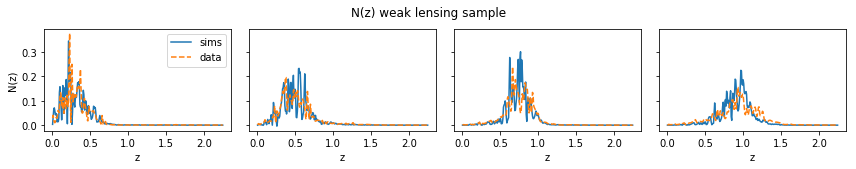

In [12]:
# ********************************************************
# PLOTSSS *********************************
# ********************************************************

fig, ax = plt.subplots(1,len(wl_sims_nz.keys()),sharey=True, figsize=(12,2.2))
for key in wl_sims_nz.keys():               
    ax[key].plot(wl_sims_nz[key]['z'],wl_sims_nz[key]['Nz']*1000,label = 'sims')
    ax[key].plot(wl_data_nz[key]['z'],wl_data_nz[key]['Nz']*1000,label = 'data',linestyle='dashed')
ax[0].legend()
ax[0].set_ylabel('N(z)')
ax[0].set_xlabel('z')
ax[1].set_xlabel('z')
ax[2].set_xlabel('z')
ax[3].set_xlabel('z')
plt.suptitle('N(z) weak lensing sample', y=1.05)
plt.tight_layout()
#plt.savefig('./figures_x_paper/Nz_sims_data.pdf',bbox_inches='tight')


# compute bias correction

/global/u1/g/giannini/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


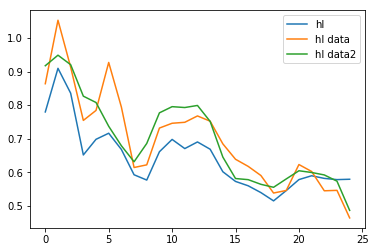

In [13]:

bias_corr_comb_data2  = np.zeros(len(bins_rm)-1)
bias_corr_hl_data2 = np.zeros(len(bins_rm)-1)
bias_corr_hl_data = np.zeros(len(bins_rm)-1)
bias_corr_comb = np.zeros(len(bins_rm)-1)
bias_corr_comb_data  = np.zeros(len(bins_rm)-1)
bias_corr_hl = np.zeros(len(bins_rm)-1)

mute_comb_data2 = pf.open(path_cosmosis+'/data_WL_rmg_rmgz_combined_data2.fits')
mute_hl_data2 = pf.open(path_cosmosis+'/data_WL_rmg_rmgz_higherlum_data2.fits')
mute_comb_data = pf.open(path_cosmosis+'/data_WL_rmg_rmgz_combined_data.fits')
mute_hl_data = pf.open(path_cosmosis+'/data_WL_rmg_rmgz_higherlum_data.fits')
mute_comb = pf.open(path_cosmosis+'/sims_WL_rmg_rmgz_combined.fits')
mute_hl = pf.open(path_cosmosis+'/sims_WL_rmg_rmgz_higherlum.fits')
mute = pf.open(path_cosmosis+'/data_WL_rmg_truez.fits')

z_hr = mute[4].data['Z_MID']
for i in range(1,len(bins_rm)):
    dd ,_ = np.histogram(np.linspace(bins_rm[i-1],bins_rm[i],5000),bins=np.hstack([mute[4].data['Z_LOW'],mute[4].data['Z_HIGH'][-1]]),normed=True)
    dd = np.trapz(dd**2,z_hr)
    bias_corr_comb_data2[i-1] = (1./dd)*np.trapz(mute_comb_data2[4].data['BIN{0}'.format(i)]**2,z_hr)
    bias_corr_comb_data[i-1] = (1./dd)*np.trapz(mute_comb_data[4].data['BIN{0}'.format(i)]**2,z_hr)
    bias_corr_comb[i-1] = (1./dd)*np.trapz(mute_comb[4].data['BIN{0}'.format(i)]**2,z_hr)
    bias_corr_hl_data[i-1] = (1./dd)*np.trapz(mute_hl_data[4].data['BIN{0}'.format(i)]**2,z_hr)
    bias_corr_hl_data2[i-1] = (1./dd)*np.trapz(mute_hl_data2[4].data['BIN{0}'.format(i)]**2,z_hr)
    
    bias_corr_hl[i-1] = (1./dd)*np.trapz(mute_hl[4].data['BIN{0}'.format(i)]**2,z_hr)

bias_corr_comb_data  = np.sqrt((bias_corr_comb_data))
bias_corr_hl_data = np.sqrt(bias_corr_hl_data)
bias_corr_comb_data2  = np.sqrt((bias_corr_comb_data2))
bias_corr_hl_data2 = np.sqrt(bias_corr_hl_data2)

bias_corr_comb = np.sqrt((bias_corr_comb))

bias_corr_hl = np.sqrt((bias_corr_hl))

dict_bias_corr = dict()
dict_bias_corr['bias_rmg_corr_higherlum_data2'] = bias_corr_hl_data2
dict_bias_corr['bias_rmg_corr_combined_data2'] = bias_corr_comb_data2
dict_bias_corr['bias_rmg_corr_higherlum_data'] = bias_corr_hl_data
dict_bias_corr['bias_rmg_corr_combined_data'] = bias_corr_comb_data
dict_bias_corr['bias_rmg_corr_combined'] = bias_corr_comb

dict_bias_corr['bias_rmg_corr_higherlum'] = bias_corr_hl
save_obj('/global/cscratch1/sd/giannini/clusteringz/y3data/data/bias_corr',dict_bias_corr)

#plt.plot(bias_corr_comb,label='comb')
plt.plot(bias_corr_hl,label='hl')
plt.plot(bias_corr_hl_data,label='hl data')
plt.plot(bias_corr_hl_data2,label='hl data2')

#plt.plot(bias_corr_comb_data2,label='comb data2')
#plt.plot(bias_corr_comb_data,label='comb data')

plt.legend()


# Read cosmosis

In [20]:
import cosmolopy.distance as cd
import cosmolopy
from scipy.interpolate import interp1d
from scipy.integrate import quad
import math

gamma = 1

scales_options = ['','_large']
min_rp_a  = [500,1500]
max_rp_a = [1500,5000]

angular_bins = 8
om = 0.286
s8 = 0.82

cosmo = {'omega_M_0':om, 
         'omega_lambda_0':1-om,
         'omega_k_0': 0.0, 
         'omega_b_0' : 0.048,
         'h':0.69,
         'sigma_8' : s8,
         'n': 0.96}



path_output = '/global/cscratch1/sd/giannini/clusteringz/output_cosmosis/'
runs = ['sims_WL_eboss',
        'data_WL_eboss',
        'data_WL_rmg_rmgz_higherlum',
        'data_WL_rmg_rmgz_combined',
        'data_WL_rmg_rmgz_higherlum_data',
        'data_WL_rmg_rmgz_combined_data',
        'data_WL_rmg_truez',
        'sims_WL_rmg_rmgz_higherlum',
        'sims_WL_rmg_rmgz_combined',
        'sims_WL_rmg_truez',
        'sims_WL_rmg_rmgz_higherlum_data',
        'sims_WL_rmg_rmgz_combined_data'
        ]
dict_cosmosis = dict()
for run in runs:
    if 'eboss' in run:
    
        if 'sims' in run:
            true = rebin(wl_sims_nz[key]['z'], wl_sims_nz[key]['Nz'], bins_eboss )
            
        if 'data' in run:
            true = rebin(wl_data_nz[key]['z'], wl_data_nz[key]['Nz'], bins_eboss )
            true=true[:-1]/np.sum(true[:-1])
    elif 'rmg' in run:
        if 'sims' in run:
            true = rebin(wl_sims_nz[key]['z'], wl_sims_nz[key]['Nz'], bins_rm )
            true=true[:-1]/np.sum(true[:-1])
        elif 'data' in run:
            true = rebin(wl_data_nz[key]['z'], wl_data_nz[key]['Nz'], bins_rm )
            true=true[:-1]/np.sum(true[:-1])
            
            
    print (run)
    fil= open(path_output+run+'/nz_source/values.txt','r')
    for f in fil:
        try:
            n_tomo_cosmosis =  np.int(f.split('nbin = ')[1])-1
        except:
            pass  
    fil.close()
    fil= open(path_output+run+'/nz_lens/values.txt','r')
    for f in fil:
        try:
            n_ref_cosmosis =  np.int(f.split('nbin = ')[1])
        except:
            pass  
    fil.close()
    
    

    
    if n_ref_cosmosis==25:
        z_ref = copy.copy(0.5*(bins_rm[1:]+bins_rm[:-1]))
    else:
        z_ref = copy.copy(0.5*(bins_eboss[1:]+bins_eboss[:-1]))
    
    mute_dict = dict()
    for kk,scale_label in enumerate(scales_options):
        
        mag_pos = np.zeros((n_tomo_cosmosis,n_ref_cosmosis))                     
        mag_pos1 = np.zeros((n_tomo_cosmosis,n_ref_cosmosis))  
        w_ur = np.zeros((n_tomo_cosmosis,n_ref_cosmosis)) 
        w_rr = np.zeros((n_tomo_cosmosis,n_ref_cosmosis)) 
    
        for j in range(n_tomo_cosmosis):
            for i in range(n_ref_cosmosis):

                min_theta_rp=(min_rp_a[kk]/(1000*(1.+z_ref[i])*cd.angular_diameter_distance(z_ref[i],**cosmo)))/((2*math.pi)/360)
                max_theta_rp=(max_rp_a[kk]/(1000*(1.+z_ref[i])*cd.angular_diameter_distance(z_ref[i],**cosmo)))/((2*math.pi)/360)

                # magnification 1st factor
                mute = np.loadtxt(path_output+run+"/mag_pos_xi/bin_{1}_{0}.txt".format(i+1,j+1))
                theta = np.loadtxt(path_output+run+"/mag_pos_xi/theta.txt")/((2*math.pi)/360)
                f = interp1d(theta,mute/theta**gamma)
                mag_pos[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]  

                # magnification 2nd factor
                mute = np.loadtxt(path_output+run+"/mag_pos_xi_2/bin_{0}_{1}.txt".format(i+1,j+1))
                f = interp1d(theta,mute/theta**gamma)
                mag_pos1[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]  


                # Nz *********************
                mute = np.loadtxt(path_output+run+"/galaxy_xi/bin_{0}_{1}.txt".format(i+1,j+1))
                f = interp1d(theta,mute/theta**gamma)
                w_ur[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]  


                mute = np.loadtxt(path_output+run+"/matter_auto_xi/bin_{0}_{1}.txt".format(i+1,i+1))
                f = interp1d(theta,mute/theta**gamma)
                w_rr[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]

        mute_dict['w_rr'] = copy.copy(w_rr)
        mute_dict['w_ur'] = copy.copy(w_ur)
        mute_dict['mag_pos'] = copy.copy(mag_pos)
        mute_dict['mag_pos1'] = copy.copy(mag_pos1)
        mute_dict['z_ref'] = copy.copy(z_ref)
        mute_dict['true_Nz'] = copy.copy(true)
        dict_cosmosis[run+scale_label] = copy.copy(mute_dict)

save_obj('/global/cscratch1/sd/giannini/clusteringz/y3data/data/dict_cosmosis',dict_cosmosis)
print ('done')

sims_WL_eboss


/global/u1/g/giannini/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:102: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/global/u1/g/giannini/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:113: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval 

data_WL_eboss
data_WL_rmg_rmgz_higherlum
data_WL_rmg_rmgz_combined
data_WL_rmg_rmgz_higherlum_data
data_WL_rmg_rmgz_combined_data
data_WL_rmg_truez
sims_WL_rmg_rmgz_higherlum


KeyboardInterrupt: 

# Diagnostic plots

('data', '', 'combined_data')


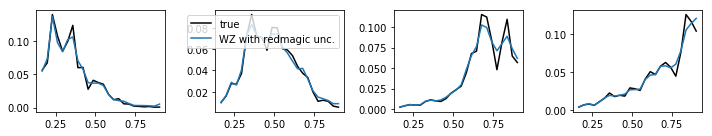

In [15]:
# plot data
def rebin(z_old, pdf_old, zbins):
        # spline
        kwargs_spline = {'s': 0,  # force spline to go through data points
                         'ext': 'zeros',  # ext=0 means extrapolate, =1 means return 0
                         'k': 3,
                        }
        spline = UnivariateSpline(z_old, pdf_old, **kwargs_spline)
        pdf = np.zeros(len(zbins) - 1)
        for i in range(len(zbins) - 1):
            zmin = zbins[i]
            zmax = zbins[i + 1]
            pdf[i] = spline.integral(zmin, zmax) #/ (zmax - zmin)
        return pdf
    
    
    
stdv=2
typ = 'sims'
sc = '_large'
rmg_l = 'combined'#higherlum_data

shifts_collection = {0:dict(),1:dict(),2:dict(),3:dict()}

typ_arr = ['data']
sc_arr= ['']
#sc_arr= ['_large','_large','_large','_large','_large','_large','_large','_large']

rmg_l_ar = ['combined_data']
for case in range(1):
    typ = typ_arr[case]
    sc = sc_arr[case]
    rmg_l= rmg_l_ar[case]
    fig, ax = plt.subplots(1,len(wl_sims_nz.keys()), figsize=(10,2))

    print (typ,sc,rmg_l)
    for key in wl_sims_nz.keys():
        shifts_collection[key]

        zz = dict_cosmosis[typ+'_WL_rmg_truez']['z_ref'][:-1]

        # ,wl_sims_nz[key]['Nz']
        if typ =='sims':
            true = rebin(wl_sims_nz[key]['z'], wl_sims_nz[key]['Nz'], bins_rm )
            true=true[:-1]/np.sum(true[:-1])
        if typ=='data':
            true = rebin(wl_data_nz[key]['z'], wl_data_nz[key]['Nz'], bins_rm )
            true=true[:-1]/np.sum(true[:-1])

        # compute interval: +-2sigma
        mean_true = compute_mean(zz,true)
        std_true = compute_std(zz,true)
        mask = (zz>(mean_true-stdv*std_true)) & (zz<(mean_true+stdv*std_true))
        mean_true_s = compute_mean(zz[mask],true[mask])
        #
        ax[key].plot(zz,true,color='black',label='true') 
        shift = mean_true_s-compute_mean(zz[mask],true[mask])
        y = dict_cosmosis[typ+'_WL_rmg_truez']['w_ur'][key,:-1]
        
        # apply the correction *******
        corr = dict_bias_corr['bias_rmg_corr_'+rmg_l]

        y = dict_cosmosis[typ+'_WL_rmg_rmgz_'+rmg_l+sc]['w_ur'][key,:-1]*corr[:-1]/np.sqrt(dict_cosmosis[typ+'_WL_rmg_truez'+sc]['w_rr'][key,:-1]*dict_cosmosis[typ+'_WL_rmg_rmgz_'+rmg_l+sc]['w_rr'][key,:-1])
        ax[key].plot(zz,y/np.sum(y),label='WZ with redmagic unc.') 
        shift = mean_true_s-compute_mean(zz[mask],y[mask])
        
plt.tight_layout()
ax[1].legend()

('sims', '', 'combined')


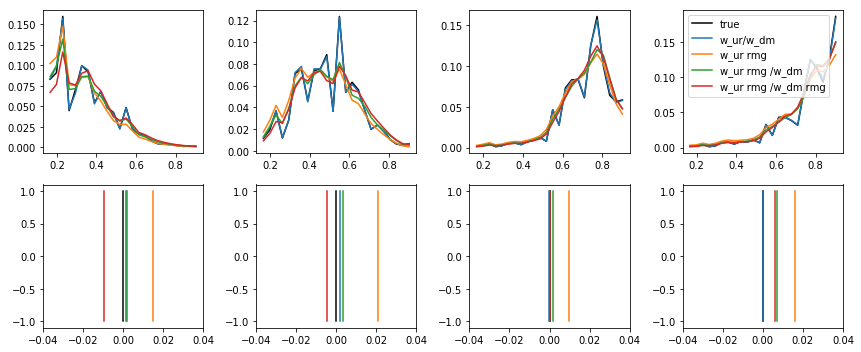

('sims', '', 'higherlum')


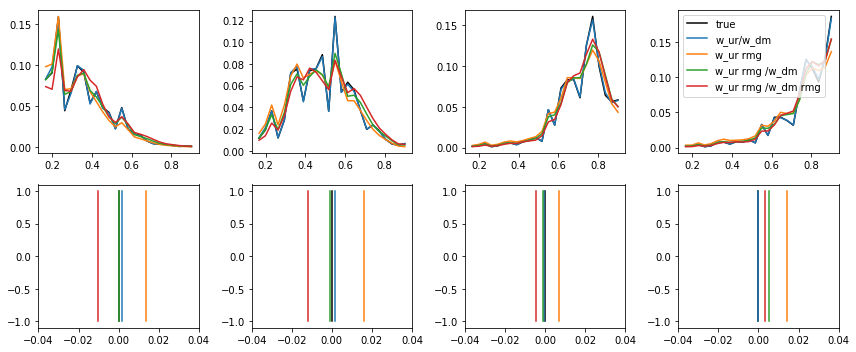

('sims', '', 'combined_data')


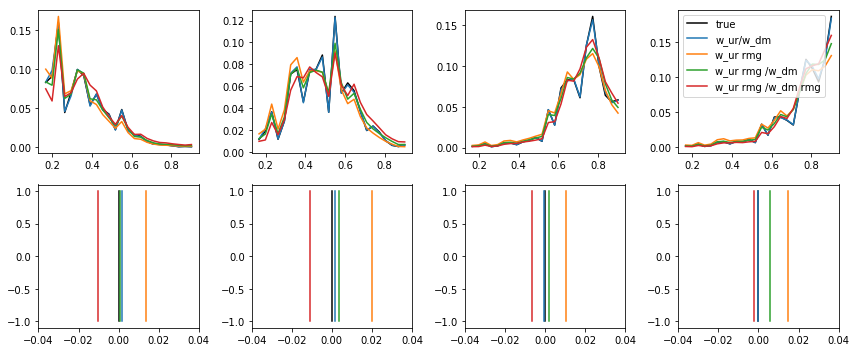

('sims', '', 'higherlum_data')


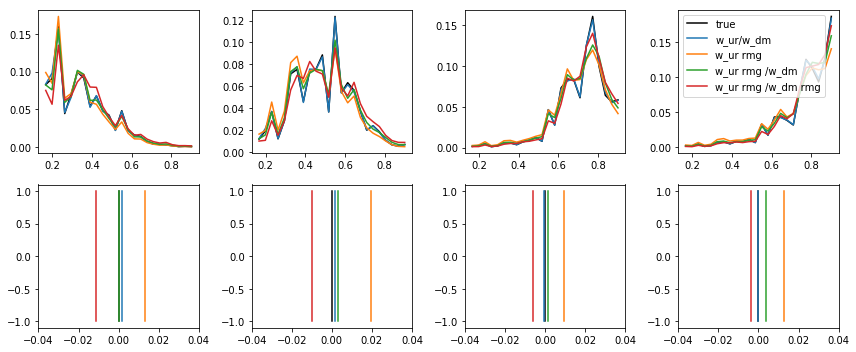

('data', '', 'combined')


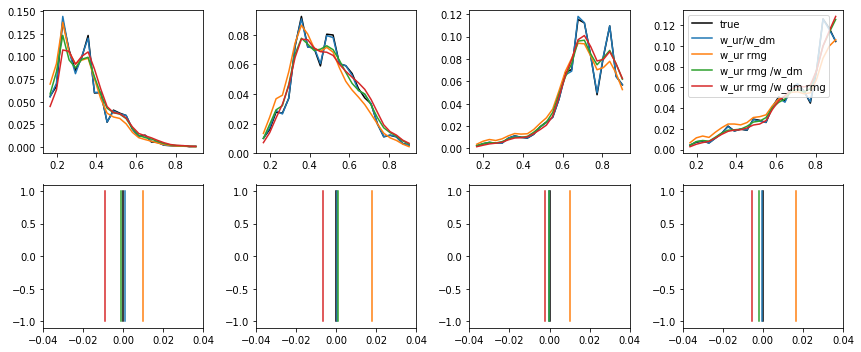

('data', '', 'higherlum')


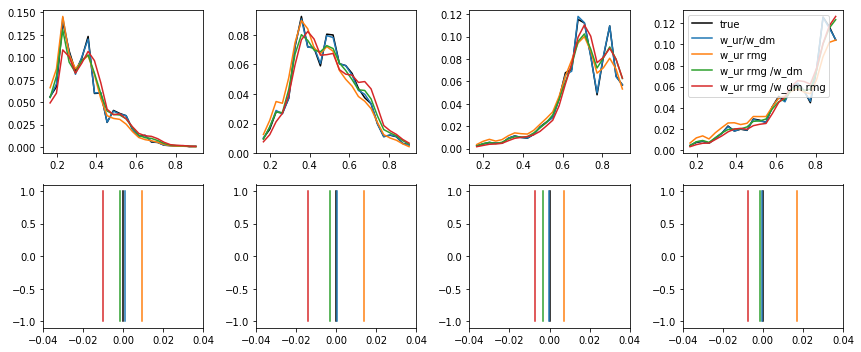

('data', '', 'combined_data')


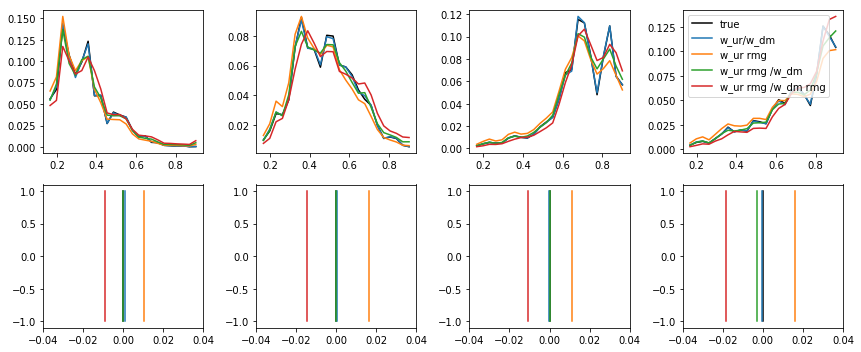

('data', '', 'higherlum_data')


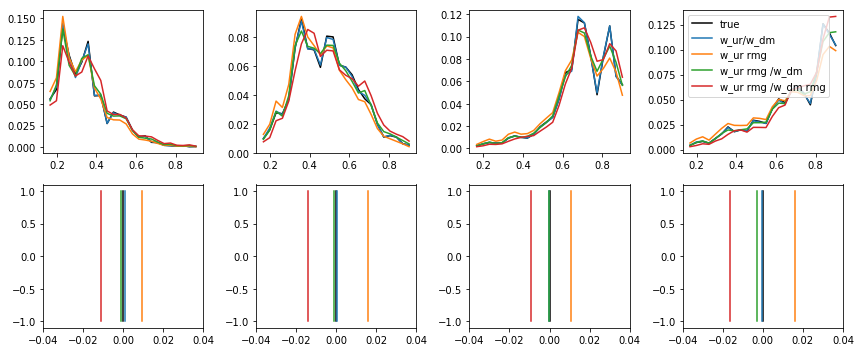

In [16]:
# plot data
def rebin(z_old, pdf_old, zbins):
        # spline
        kwargs_spline = {'s': 0,  # force spline to go through data points
                         'ext': 'zeros',  # ext=0 means extrapolate, =1 means return 0
                         'k': 3,
                        }
        spline = UnivariateSpline(z_old, pdf_old, **kwargs_spline)
        pdf = np.zeros(len(zbins) - 1)
        for i in range(len(zbins) - 1):
            zmin = zbins[i]
            zmax = zbins[i + 1]
            pdf[i] = spline.integral(zmin, zmax) #/ (zmax - zmin)
        return pdf
    
    
    
stdv=2
typ = 'sims'
sc = '_large'
rmg_l = 'combined'#higherlum_data

shifts_collection = {0:dict(),1:dict(),2:dict(),3:dict()}

typ_arr = ['sims','sims','sims','sims','data','data','data','data']
sc_arr= ['','','','','','','','']
#sc_arr= ['_large','_large','_large','_large','_large','_large','_large','_large']

rmg_l_ar = ['combined','higherlum','combined_data','higherlum_data','combined','higherlum','combined_data','higherlum_data']
for case in range(8):
    typ = typ_arr[case]
    sc = sc_arr[case]
    rmg_l= rmg_l_ar[case]
    fig, ax = plt.subplots(2,len(wl_sims_nz.keys()), figsize=(12,5))

    print (typ,sc,rmg_l)
    for key in wl_sims_nz.keys():
        shifts_collection[key]

        zz = dict_cosmosis[typ+'_WL_rmg_truez']['z_ref'][:-1]

        # ,wl_sims_nz[key]['Nz']
        if typ =='sims':
            true = rebin(wl_sims_nz[key]['z'], wl_sims_nz[key]['Nz'], bins_rm )
            true=true[:-1]/np.sum(true[:-1])
        if typ=='data':
            true = rebin(wl_data_nz[key]['z'], wl_data_nz[key]['Nz'], bins_rm )
            true=true[:-1]/np.sum(true[:-1])

        # compute interval: +-2sigma
        mean_true = compute_mean(zz,true)
        std_true = compute_std(zz,true)
        mask = (zz>(mean_true-stdv*std_true)) & (zz<(mean_true+stdv*std_true))
        mean_true_s = compute_mean(zz[mask],true[mask])
        #
        ax[0,key].plot(zz,true,color='black',label='true') 
        shift = mean_true_s-compute_mean(zz[mask],true[mask])
        ax[1,key].plot([shift,shift],[-1,1],color='black',label='true') 
        y = dict_cosmosis[typ+'_WL_rmg_truez']['w_ur'][key,:-1]
        
        #ax[key].plot(zz,y/np.sum(y),label='w_ur') 
        y = dict_cosmosis[typ+'_WL_rmg_truez'+sc]['w_ur'][key,:-1]/dict_cosmosis[typ+'_WL_rmg_truez'+sc]['w_rr'][key,:-1]
        ax[0,key].plot(zz,y/np.sum(y),label='w_ur/w_dm')   
        shift = mean_true_s-compute_mean(zz[mask],y[mask])
        ax[1,key].plot([shift,shift],[-1,1],label='w_ur/w_dm')   

        shifts_collection[key][typ+'w_ur/w_dm'+sc] = shift
        
        y = dict_cosmosis[typ+'_WL_rmg_truez'+sc]['w_ur'][key,:-1]
        shift = mean_true_s-compute_mean(zz[mask],y[mask])
        shifts_collection[key][typ+'w_ur'+sc] = shift



        y = dict_cosmosis[typ+'_WL_rmg_rmgz_'+rmg_l+sc]['w_ur'][key,:-1]
        ax[0,key].plot(zz,y/np.sum(y),label='w_ur rmg') 
        shift = mean_true_s-compute_mean(zz[mask],y[mask])
        ax[1,key].plot([shift,shift],[-1,1],label='w_ur rmg') 

        shifts_collection[key][typ+'w_ur_'+rmg_l+sc] = shift
        
        
        
        
        # apply the correction *******
        corr = dict_bias_corr['bias_rmg_corr_'+rmg_l]

        y = dict_cosmosis[typ+'_WL_rmg_rmgz_'+rmg_l+sc]['w_ur'][key,:-1]*corr[:-1]/np.sqrt(dict_cosmosis[typ+'_WL_rmg_truez'+sc]['w_rr'][key,:-1]*dict_cosmosis[typ+'_WL_rmg_rmgz_'+rmg_l+sc]['w_rr'][key,:-1])
        ax[0,key].plot(zz,y/np.sum(y),label='w_ur rmg /w_dm') 
        shift = mean_true_s-compute_mean(zz[mask],y[mask])
        ax[1,key].plot([shift,shift],[-1,1],label='w_ur rmg /w_dm') 

        shifts_collection[key][typ+'w_ur_'+rmg_l+sc+' /w_dm'] = shift
        
        
        
        
        
        
        
        y = dict_cosmosis[typ+'_WL_rmg_rmgz_'+rmg_l+sc]['w_ur'][key,:-1]/np.sqrt(dict_cosmosis[typ+'_WL_rmg_truez'+sc]['w_rr'][key,:-1]*dict_cosmosis[typ+'_WL_rmg_rmgz_'+rmg_l+sc]['w_rr'][key,:-1])
        ax[0,key].plot(zz,y/np.sum(y),label='w_ur rmg /w_dm rmg') 
        shift = mean_true_s-compute_mean(zz[mask],y[mask])
        ax[1,key].plot([shift,shift],[-1,1],label='w_ur rmg /w_dm rmg') 

        shifts_collection[key][typ+'w_ur_'+rmg_l+sc+' /w_dm rmg'] = shift
        
        #ax[key].plot(wl_sims_nz[key]['z'],wl_sims_nz[key]['Nz'],label = 'sims')
        #ax[key].plot(wl_data_nz[key]['z'],wl_data_nz[key]['Nz'],label = 'data')
    ax[0,3].legend()
    ax[1,0].set_xlim([-0.04,0.04])
    ax[1,1].set_xlim([-0.04,0.04])
    ax[1,2].set_xlim([-0.04,0.04])
    ax[1,3].set_xlim([-0.04,0.04])
    plt.tight_layout()
    plt.show()
    
    
    
    
    
    
    
    


('sims', '', '')


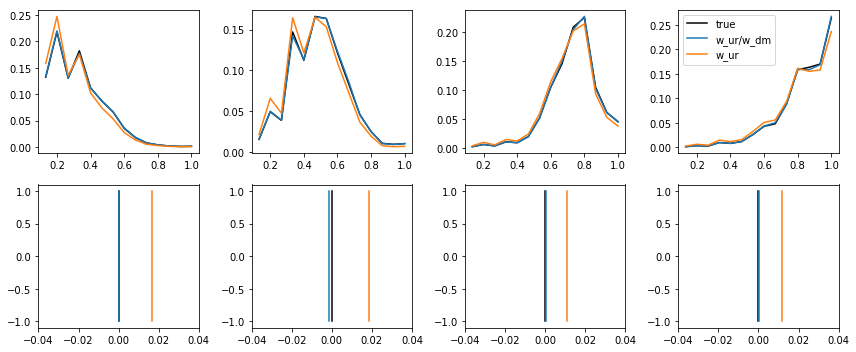

('data', '', '')


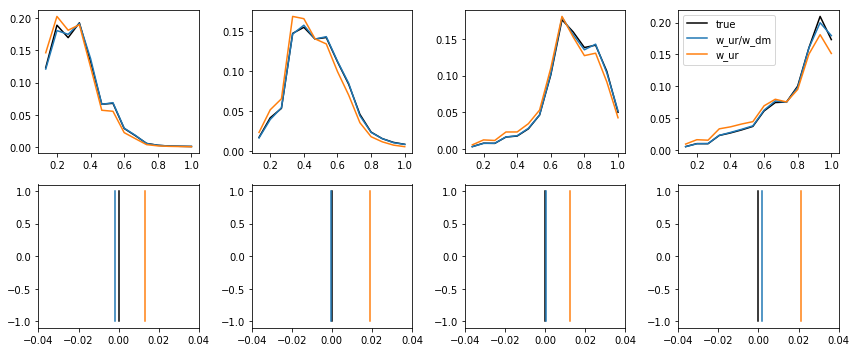

In [17]:
shifts_collection_eboss = {0:dict(),1:dict(),2:dict(),3:dict()}

typ_arr = ['sims','data']
sc_arr= ['','']
rmg_l_ar = ['','']
for case in range(2):
    typ = typ_arr[case]
    sc = sc_arr[case]
    rmg_l= rmg_l_ar[case]
    fig, ax = plt.subplots(2,len(wl_sims_nz.keys()), figsize=(12,5))

    print (typ,sc,rmg_l)
    for key in wl_sims_nz.keys():
        shifts_collection[key]

        zz = dict_cosmosis[typ+'_WL_eboss']['z_ref'][:-1]

        # ,wl_sims_nz[key]['Nz']
        if typ =='sims':
            true = rebin(wl_sims_nz[key]['z'], wl_sims_nz[key]['Nz'], bins_eboss )
            true=true[:-1]/np.sum(true[:-1])
        if typ=='data':
            true = rebin(wl_data_nz[key]['z'], wl_data_nz[key]['Nz'], bins_eboss )
            true=true[:-1]/np.sum(true[:-1])

        # compute interval: +-2sigma
        mean_true = compute_mean(zz,true)
        std_true = compute_std(zz,true)
        mask = (zz>(mean_true-stdv*std_true)) & (zz<(mean_true+stdv*std_true))
        mean_true_s = compute_mean(zz[mask],true[mask])
        #
        ax[0,key].plot(zz,true,color='black',label='true') 
        shift = mean_true_s-compute_mean(zz[mask],true[mask])
        ax[1,key].plot([shift,shift],[-1,1],color='black',label='true') 
        
       
        y = dict_cosmosis[typ+'_WL_eboss'+sc]['w_ur'][key,:-1]/dict_cosmosis[typ+'_WL_eboss'+sc]['w_rr'][key,:-1]
        ax[0,key].plot(zz,y/np.sum(y),label='w_ur/w_dm')   
        shift = mean_true_s-compute_mean(zz[mask],y[mask])
        ax[1,key].plot([shift,shift],[-1,1],label='w_ur/w_dm')   

        shifts_collection_eboss[key][typ+'w_ur/w_dm'+sc] = shift
        
        y = dict_cosmosis[typ+'_WL_eboss'+sc]['w_ur'][key,:-1]
        shift = mean_true_s-compute_mean(zz[mask],y[mask])
        ax[0,key].plot(zz,y/np.sum(y),label='w_ur')   
        ax[1,key].plot([shift,shift],[-1,1],label='w_ur')   
        shifts_collection_eboss[key][typ+'w_ur'+sc] = shift


        #ax[key].plot(wl_sims_nz[key]['z'],wl_sims_nz[key]['Nz'],label = 'sims')
        #ax[key].plot(wl_data_nz[key]['z'],wl_data_nz[key]['Nz'],label = 'data')
    ax[0,3].legend()
    ax[1,0].set_xlim([-0.04,0.04])
    ax[1,1].set_xlim([-0.04,0.04])
    ax[1,2].set_xlim([-0.04,0.04])
    ax[1,3].set_xlim([-0.04,0.04])
    plt.tight_layout()
    plt.show()

[ 0.01141979  0.00081172 -0.00074011 -0.00896384 -0.00150929 -0.01009486]
[ 0.01470389  0.00148978  0.0018997  -0.00925717  0.00038457 -0.01027635]
[ 0.01725756  0.00046783  0.00067233 -0.00685457 -0.00332095 -0.01405946]
[ 0.01860818  0.00176618  0.00344474 -0.00465574 -0.00105658 -0.01204209]
[ 0.00999909 -0.00043222 -0.00015044 -0.00239892 -0.0033607  -0.00721719]
[ 0.00755099 -0.00037494  0.00173149  0.00031413 -0.00127257 -0.00435661]
[ 0.01842159 -0.00052501 -0.00175045 -0.00546535 -0.00160485 -0.00727962]
[ 8.71801858e-03 -7.87032208e-05  7.07081081e-03  6.06979294e-03
  5.40953002e-03  3.28819345e-03]


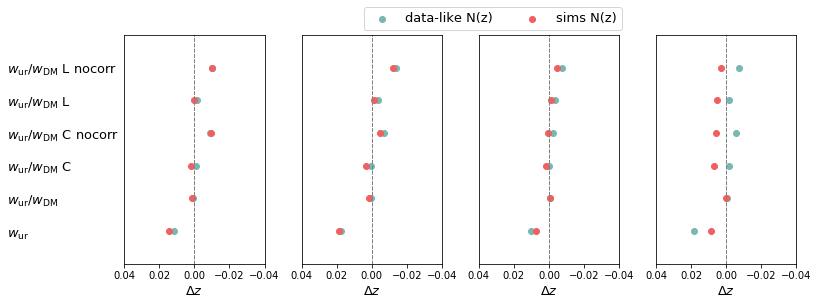

In [18]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

c_2=rgb_to_hex((239, 96, 96))
c_3=rgb_to_hex((255, 194, 0)) 
c_23=rgb_to_hex((121, 183, 179)) 
def plot_1d(array, truth_id, ax, label, legend=0,color=c_2,lab=''):
    print array
    ax.plot([truth[truth_id], truth[truth_id]], [-1,13], color='grey', ls='--', lw=1)
    ax.set_ylim(-1,len(array))
    ax.scatter(array, np.arange(len(array)), marker='o', color=color,label=lab)

            
    ax.set_yticks([-10.0])
    ax.set_yticklabels([''])
    ax.set_xlabel(label,size=13)
  
labb = np.array([r'$w_{\rm ur}$',
r'$w_{\rm ur}/w_{\rm DM}$',
r'$w_{\rm ur}/w_{\rm DM}$ C',
#r'$w_{\rm ur}/w_{\rm DM}$ rC data',

r'$w_{\rm ur}/w_{\rm DM}$ C nocorr',
#r'$w_{\rm ur}/w_{\rm DM}$ rC data nocorr',
r'$w_{\rm ur}/w_{\rm DM}$ L',
#r'$w_{\rm ur}/w_{\rm DM}$ rL data',

r'$w_{\rm ur}/w_{\rm DM}$ L nocorr',
            
#r'$w_{\rm ur}/w_{\rm DM}$ rL data nocorr',
                 ])
array_sims=[]
for key in wl_sims_nz.keys():
    array_sims.append(np.array([
shifts_collection[key]['simsw_ur'],
shifts_collection[key]['simsw_ur/w_dm'],

shifts_collection[key]['simsw_ur_combined /w_dm'],
#shifts_collection[key]['simsw_ur_combined_data /w_dm'],
        
shifts_collection[key]['simsw_ur_combined /w_dm rmg'],
#shifts_collection[key]['simsw_ur_combined_data /w_dm rmg'],
shifts_collection[key]['simsw_ur_higherlum /w_dm'],
#shifts_collection[key]['simsw_ur_higherlum_data /w_dm'],
        
shifts_collection[key]['simsw_ur_higherlum /w_dm rmg'],
#shifts_collection[key]['simsw_ur_higherlum_data /w_dm rmg'],
    ]))
array_data=[]
for key in wl_sims_nz.keys():
    array_data.append(np.array([
shifts_collection[key]['dataw_ur'],
shifts_collection[key]['dataw_ur/w_dm'],

shifts_collection[key]['dataw_ur_combined /w_dm'],
#shifts_collection[key]['dataw_ur_combined_data /w_dm'],
        
shifts_collection[key]['dataw_ur_combined /w_dm rmg'],
#shifts_collection[key]['dataw_ur_combined_data /w_dm rmg'],
shifts_collection[key]['dataw_ur_higherlum /w_dm'],
#shifts_collection[key]['dataw_ur_higherlum_data /w_dm'],
        
shifts_collection[key]['dataw_ur_higherlum /w_dm rmg'],
#shifts_collection[key]['dataw_ur_higherlum_data /w_dm rmg'],
    ]))

xmin=-0.04
xmax=-0.04
truth = np.zeros(4)
plt.figure(figsize=(10,4))
ax0 = plt.subplot(141)
plot_1d(array_data[0], 0, ax0, r'$\Delta z$', legend=0,color=c_23,lab='data-like N(z)')
plot_1d(array_sims[0], 0, ax0, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)
ax1 = plt.subplot(142)
plot_1d(array_data[1], 1, ax1, r'$\Delta z$', legend=0,color=c_23,lab='data-like N(z)')
plot_1d(array_sims[1], 1, ax1, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)
ax2 = plt.subplot(143)
plot_1d(array_data[2], 2, ax2, r'$\Delta z$', legend=0,color=c_23,lab='data-like N(z)')
plot_1d(array_sims[2], 2, ax2, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)
ax3 = plt.subplot(144)
plot_1d(array_data[3], 3, ax3, r'$\Delta z$', legend=0,color=c_23,lab='data-like N(z)')
plot_1d(array_sims[3], 3, ax3, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)
#plt.legend(bbox_to_anchor=(-0.2,1.15),ncol = 3, fontsize=13)
uu = 0.41
#plt.text(uu,11.8,"Scale cut", fontsize=13)
#plt.text(uu,10.8,r"$12 h^{-1}$ Mpc", fontsize=13)
#plt.text(uu,9.8 ,labb[], fontsize=13)
#plt.text(uu,8.8 ,labb[9], fontsize=13)
#plt.text(uu,7.8 ,labb[8], fontsize=13)
#plt.text(uu,6.8 ,labb[7], fontsize=13)
#plt.text(uu,5.8 ,labb[6], fontsize=13)
plt.text(uu,4.8 ,labb[5], fontsize=13)
plt.text(uu,3.8 ,labb[4], fontsize=13)
plt.text(uu,2.8 ,labb[3], fontsize=13)
plt.text(uu,1.8 ,labb[2], fontsize=13)
plt.text(uu,0.8 ,labb[1], fontsize=13)
plt.text(uu,-0.2,labb[0], fontsize=13)
plt.tight_layout()
plt.legend(bbox_to_anchor=(-0.2,1.15),ncol = 3, fontsize=13)
#plt.savefig('./figures_x_paper/mean_shifts_cosmosis.pdf',bbox_inches='tight')


# magnification 

In [24]:
key = 'sims_WL_rmg_rmgz_combined_data_large'
dict_cosmosis[key].keys()

['z_ref', 'w_rr', 'mag_pos1', 'w_ur', 'mag_pos', 'true_Nz']

In [ ]:
fig, ax = plt.subplots(1,len(wl_sims_nz.keys()), figsize=(10,2))
    plt.plot(dict_cosmosis

# checks on integration interval & cosmology

In [112]:
import sys
sys.path.insert(0, '/global/homes/g/giannini/clustering-z/WZ_utils/')
from covariance_routines import *
from load_routines import *



n_jck=100
gamma = 1
zmin=0.15
zmax=0.95
bins = 25
ang_bins = 8

info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}

path_base = '/global/cscratch1/sd/mgatti/clustering_z/mastercat_12_3_19_'

to_read = ['rmg_R_w/',
]

dict_rmg = read_results_fast(path_base+'rmg_R_w/',n_jck,gamma,ang_bins)
dict_rmg_large = read_results_fast(path_base+'rmg_R_w_1500_5000/',n_jck,gamma,ang_bins)
         
    
    
n_jck=100
gamma = 1
zmin=0.1
zmax=1.1
bins = 15
ang_bins = 8

dict_eboss = read_results_fast(path_base+'eboss_R_w/',n_jck,gamma,ang_bins)
dict_eboss_large = read_results_fast(path_base+'eboss_R_w_1500_5000/',n_jck,gamma,ang_bins)
          

/global/homes/m/mgatti/clustering-z/WZ_utils/load_routines.py:25: RuntimeWarning: invalid value encountered in double_scalars
  norm=[1.,ndd/ndr,ndd/nrd,ndd/nrr]
/global/homes/m/mgatti/clustering-z/WZ_utils/load_routines.py:52: RuntimeWarning: invalid value encountered in double_scalars
  norm=[1.,ndd/ndr,ndd/nrd,ndd/nrr]


In [224]:
import cosmolopy.distance as cd
import cosmolopy
from scipy.interpolate import interp1d
from scipy.integrate import quad
import math

gamma = 1

scales_options = ['','_large']
min_rp_a  = [500,1500]
max_rp_a = [1500,5000]

angular_bins = 8
om = 0.286
s8 = 0.82

cosmo = {'omega_M_0':om, 
         'omega_lambda_0':1-om,
         'omega_k_0': 0.0, 
         'omega_b_0' : 0.048,
         'h':0.69,
         'sigma_8' : s8,
         'n': 0.96}



om = 0.35
s8 = 0.7

cosmo1 = {'omega_M_0':om, 
         'omega_lambda_0':1-om,
         'omega_k_0': 0.0, 
         'omega_b_0' : 0.048,
         'h':0.69,
         'sigma_8' : s8,
         'n': 0.96}




path_output = '/global/homes/m/mgatti/clustering-z/cosmosis_output/'
runs = ['sims_WL_eboss',
        'sims_WL_rmg_truez',
        'sims_WL_rmg_truez_cosmo_wrong',
        ]
checks_cosmosis = dict()
for run in runs:
    print (run)
    fil= open(path_output+run+'/nz_source/values.txt','r')
    for f in fil:
        try:
            n_tomo_cosmosis =  np.int(f.split('nbin = ')[1])-1
        except:
            pass  
    fil.close()
    fil= open(path_output+run+'/nz_lens/values.txt','r')
    for f in fil:
        try:
            n_ref_cosmosis =  np.int(f.split('nbin = ')[1])
        except:
            pass  
    fil.close()
    
    
   
    if n_ref_cosmosis==25:
        z_ref = copy.copy(0.5*(bins_rm[1:]+bins_rm[:-1]))
    else:
        z_ref = copy.copy(0.5*(bins_eboss[1:]+bins_eboss[:-1]))
        dict_ref = copy.copy(dict_eboss)

    if 1==1:
        mag_pos = np.zeros((n_tomo_cosmosis,n_ref_cosmosis))                     
        mag_pos1 = np.zeros((n_tomo_cosmosis,n_ref_cosmosis))  
        w_ur = np.zeros((n_tomo_cosmosis,n_ref_cosmosis)) 
        w_rr = np.zeros((n_tomo_cosmosis,n_ref_cosmosis)) 
        w_ur_tree = np.zeros((n_tomo_cosmosis,n_ref_cosmosis)) 
        w_rr_tree = np.zeros((n_tomo_cosmosis,n_ref_cosmosis)) 

        w_ur_cosmo_wrong_interval = np.zeros((n_tomo_cosmosis,n_ref_cosmosis)) 
        w_rr_cosmo_wrong_interval = np.zeros((n_tomo_cosmosis,n_ref_cosmosis)) 
 

    for kk,scale_label in enumerate(scales_options):
        mute_dict = dict()
        


        if len(z_ref)==15:
            if scale_label == '_large':
                print ('eboss large')
                dict_ref = copy.copy(dict_eboss_large)
            else:
                print ('eboss')
                dict_ref = copy.copy(dict_eboss)
        elif len(z_ref)==25:
            if scale_label == '_large':
                print ('rmg large')
                dict_ref = copy.copy(dict_rmg_large)
            else:
                print ('rmg')
                dict_ref = copy.copy(dict_rmg)     
        #if 1==1:   
        for j in range(n_tomo_cosmosis):
            for i in range(n_ref_cosmosis):
                #j=0
                #i=1
                #'''
                min_theta_rp=(min_rp_a[kk]/(1000*(1.+z_ref[i])*cd.angular_diameter_distance(z_ref[i],**cosmo)))/((2*math.pi)/360)
                max_theta_rp=(max_rp_a[kk]/(1000*(1.+z_ref[i])*cd.angular_diameter_distance(z_ref[i],**cosmo)))/((2*math.pi)/360)
                
                
                min_theta_rp_cosmowrong=(min_rp_a[kk]/(1000*(1.+z_ref[i])*cd.angular_diameter_distance(z_ref[i],**cosmo1)))/((2*math.pi)/360)
                max_theta_rp_cosmowrong=(max_rp_a[kk]/(1000*(1.+z_ref[i])*cd.angular_diameter_distance(z_ref[i],**cosmo1)))/((2*math.pi)/360)

                
                # Nz *********************
                mute = np.loadtxt(path_output+run+"/galaxy_xi/bin_{0}_{1}.txt".format(i+1,j+1))
                f = interp1d(theta,mute/theta**gamma)
                w_ur[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]  
                w_ur_cosmo_wrong_interval[j,i] = quad(f,min_theta_rp_cosmowrong,max_theta_rp_cosmowrong)[0]  
                w_ur_tree[j,i] = np.trapz(f(dict_ref['theta_arr'][j,:,i]),dict_ref['theta_arr'][j,:,i])


                mute = np.loadtxt(path_output+run+"/matter_auto_xi/bin_{0}_{1}.txt".format(i+1,i+1))
                f = interp1d(theta,mute/theta**gamma)
                
                w_rr[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]
                w_rr_cosmo_wrong_interval[j,i] = quad(f,min_theta_rp_cosmowrong,max_theta_rp_cosmowrong)[0]         
                w_rr_tree[j,i] = np.trapz(f(dict_ref['theta_arr'][j,:,i]),dict_ref['theta_arr'][j,:,i])
                #'''
                
                
        mute_dict['w_rr'] = copy.copy(w_rr)
        mute_dict['w_ur'] = copy.copy(w_ur)
        mute_dict['w_ur_tree'] = copy.copy(w_ur_tree)
        mute_dict['w_rr_tree'] = copy.copy(w_rr_tree)
        mute_dict['w_ur_cw'] = copy.copy(w_ur_cosmo_wrong_interval)
        mute_dict['w_rr_cw'] = copy.copy(w_rr_cosmo_wrong_interval)
        mute_dict['z_ref'] = copy.copy(z_ref)
        checks_cosmosis[run+scale_label] = copy.copy(mute_dict)
#save_obj('/global/cscratch1/sd/mgatti/clustering_z/data/dict_cosmosis',dict_cosmosis)
print ('done')

sims_WL_eboss
eboss
eboss large
sims_WL_rmg_truez
rmg
rmg large
sims_WL_rmg_truez_cosmo_wrong
rmg
rmg large
done


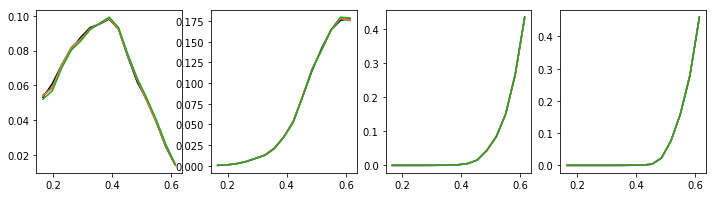

In [226]:
fig, ax = plt.subplots(1,len(wl_sims_nz.keys()), figsize=(12,3))

minx=0
maxx=15
# test interpolation *********************************

for key in wl_sims_nz.keys():
    zz = dict_cosmosis['sims_WL_rmg_truez']['z_ref'][:-1]

    true = rebin(wl_sims_nz[key]['z'], wl_sims_nz[key]['Nz'], bins_rm)
    true = true[:-1]
    true=true[minx:maxx]/np.sum(true[minx:maxx])
    ax[key].plot(zz[minx:maxx],true,color='black',label='true') 
    
    #y = checks_cosmosis['sims_WL_rmg_truez']['w_ur'][key,:-1]/checks_cosmosis['sims_WL_rmg_truez']['w_rr'][key,:-1]
    #ax[key].plot(zz,y/np.sum(y),label='w_ur/w_dm')   
        
    #y = checks_cosmosis['sims_WL_rmg_truez']['w_ur_tree'][key,:-1]/checks_cosmosis['sims_WL_rmg_truez']['w_rr_tree'][key,:-1]
    #ax[key].plot(zz,y/np.sum(y),label='w_ur/w_dm tree')  
    
    y = checks_cosmosis['sims_WL_rmg_truez']['w_ur_tree'][key,:-1]/checks_cosmosis['sims_WL_rmg_truez']['w_rr'][key,:-1]
    ax[key].plot(zz[minx:maxx],y[minx:maxx]/np.sum(y[minx:maxx]),label='w_ur/w_dm tree 1')  
    
    y = checks_cosmosis['sims_WL_rmg_truez']['w_ur'][key,:-1]/checks_cosmosis['sims_WL_rmg_truez']['w_rr_cw'][key,:-1]
    ax[key].plot(zz[minx:maxx],y[minx:maxx]/np.sum(y[minx:maxx]),label='w_ur/w_dm cw int')  
    
    y = checks_cosmosis['sims_WL_rmg_truez_cosmo_wrong']['w_ur'][key,:-1]/checks_cosmosis['sims_WL_rmg_truez']['w_rr'][key,:-1]
    ax[key].plot(zz[minx:maxx],y[minx:maxx]/np.sum(y[minx:maxx]),label='w_ur/w_dm cw all')  
    

# read cosmology unc.

In [14]:
import cosmolopy.distance as cd
import cosmolopy
from scipy.interpolate import interp1d
from scipy.integrate import quad
import math


min_rp  = 2000
max_rp = 5000
bins_ref = 10

min_rp  = 500
max_rp = 1500
bins_ref = 20

angular_bins = 8
z_ref = np.linspace(zmin,zmax,bins+1)

global n_z_theory_jk,auto_theory_jk,mag_pos_jk,auto_ref_const_jk
n_z_theory_jk = np.zeros((4,bins_ref,101))
n_z_theory_jk_wrong = np.zeros((4,bins_ref,101))
auto_theory_jk = np.zeros((4,bins_ref,101))
mag_pos_jk = np.zeros((4,bins_ref,101))
auto_ref_const_jk = np.zeros((4,bins_ref,101))


om_ar = np.zeros(101)
ob_ar = np.zeros(101)
h0_ar = np.zeros(101)
ns_ar = np.zeros(101)
s8_ar = np.zeros(101)


import os
import shutil
from multiprocessing import Pool

for jk in range(101):
    folder_run = "/global/homes/m/mgatti/clustering-z/cosmosis/multi/out_{0}/".format(jk)
    mme = open(folder+"cosmological_parameters/values.txt","r")
    for f in mme:
        
        if "n_s" in f:
            ns_ar[jk] =  f.split("n_s")[1].split("=")[1].split("\n")[0]
        if "sigma8_input" in f:
            s8_ar[jk] =  f.split("sigma8_input")[1].split("=")[1].split("\n")[0]
        
        if "omega_b" in f:
            ob_ar[jk] =  f.split("omega_b")[1].split("=")[1].split("\n")[0]
        if "omega_m" in f:
            om_ar[jk] =  f.split("omega_m")[1].split("=")[1].split("\n")[0]
        if "h0" in f:
            h0_ar[jk] =  f.split("h0")[1].split("=")[1].split("\n")[0]

def read_file(jk):  
    folder = "/global/homes/m/mgatti/clustering-z/cosmosis/multi/out_{0}/".format(jk)
    mme = open(folder+"cosmological_parameters/values.txt","r")
    for f in mme:
        
        if "n_s" in f:
            ns_ar[jk] =  f.split("n_s")[1].split("=")[1].split("\n")[0]
        if "sigma8_input" in f:
            s8_ar[jk] =  f.split("sigma8_input")[1].split("=")[1].split("\n")[0]
        
        if "omega_b" in f:
            ob_ar[jk] =  f.split("omega_b")[1].split("=")[1].split("\n")[0]
        if "omega_m" in f:
            om_ar[jk] =  f.split("omega_m")[1].split("=")[1].split("\n")[0]
        if "h0" in f:
            h0_ar[jk] =  f.split("h0")[1].split("=")[1].split("\n")[0]

            
    cosmo = {'omega_M_0':om_ar[jk], 
         'omega_lambda_0':1-om_ar[jk],
         'omega_k_0': 0.0, 
         'omega_b_0' : ob_ar[jk],
         'h':h0_ar[jk],
         'sigma_8' : s8_ar[jk],
         'n': ns_ar[jk]}

    

    for j in range(4):
        for i in range(bins_ref):
            dz =0.5*( z_ref[1]-z_ref[0])
            #theta_out = clean_2000_5000_10['theta_arr'][j,:,i]
            theta_out = runs[0]['theta_arr'][j,:,i]

            # *****  mag pos  *************
            mute = np.loadtxt(folder+"/mag_pos_xi/bin_{1}_{0}.txt".format(i+1,j+1))
            theta = np.loadtxt(folder+"/mag_pos_xi/theta.txt")/((2*math.pi)/360)
            min_theta_rp=(min_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
            max_theta_rp=(max_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
            f = interp1d(theta,mute/theta**gamma)
            mag_pos_jk[j,i,jk] = quad(f,min_theta_rp,max_theta_rp)[0]  
            
            # ****** NZ *******************
            mute = np.loadtxt(folder+"/galaxy_xi/bin_{0}_{1}.txt".format(i+1,j+1))
            f = interp1d(theta,mute/theta**gamma)
            n_z_theory_jk[j,i,jk] = quad(f,min_theta_rp,max_theta_rp)[0]
            n_z_theory_jk_wrong[j,i,jk] = quad(f,theta_out[0],theta_out[-1])[0]
            if n_z_theory_jk_wrong[j,i,jk]<0:
                n_z_theory_jk_wrong[j,i,jk]=n_z_theory_jk_wrong[j,i-1,jk]
                n_z_theory_jk[j,i,jk]=n_z_theory_jk[j,i-1,jk]
            # ****** AUTO_CONST *******************
            mute = np.loadtxt(folder+"/galaxy_xi/bin_{0}_{1}.txt".format(5,j+1))
            f = interp1d(theta,mute/theta**gamma)
            auto_ref_const_jk[j,i,jk] = quad(f,min_theta_rp,max_theta_rp)[0]


            mute = np.loadtxt(folder+"/matter_auto_xi/bin_{0}_{1}.txt".format(i+1,i+1))
            f = interp1d(theta,mute/theta**gamma)
            auto_theory_jk[j,i,jk] = quad(f,min_theta_rp,max_theta_rp)[0]
            if auto_theory_jk[j,i,jk]<0:
                 auto_theory_jk[j,i,jk]= auto_theory_jk[j,i-1,jk]

    return [jk,n_z_theory_jk[:,:,jk],n_z_theory_jk_wrong[:,:,jk],auto_theory_jk[:,:,jk],auto_ref_const_jk[:,:,jk],mag_pos_jk[:,:,jk]]
       
sims = range(101)
agents = 101
from contextlib import closing
#read_file(0)

mm = []
with closing(Pool(processes=agents)) as pool:
    mm.append(pool.map(read_file, sims))
for i in range(agents):
    jk = mm[0][i][0]
    n_z_theory_jk[:,:,jk] = mm[0][i][1]
    n_z_theory_jk_wrong[:,:,jk] =mm[0][i][2]
    auto_theory_jk[:,:,jk] = mm[0][i][3]
    mag_pos_jk[:,:,jk] = mm[0][i][5]
    auto_ref_const_jk = mm[0][i][4]

NameError: name 'folder' is not defined

In [24]:
import pyfits as pf
nz_true = pf.open("./cosmosis/run_cosmosis_20.fits")
nz_rmg = pf.open("./cosmosis/run_cosmosis_20_rmg.fits")

save_all = dict()
save_all["n_jck"] = n_jck
save_all["runs"]=runs
save_all["b_wl"]  = b_wl

save_all["nz_true"]=nz_true
save_all["nz_rmg"] = nz_rmg

save_all["angular_bins"]=angular_bins
save_all["bins_ref"] = bins_ref


save_all["nz_theory"] =n_z_theory1
save_all["rnz_theory"] =rn_z_theory1
save_all["auto_theory"] = auto_theory1
save_all["auto_theory_jk"] = auto_theory_jk

save_all["rauto_theory"] = rauto_theory1

save_all["auto_theory_arr"] = auto_theory_arr
save_all["rauto_theory_arr"] = rauto_theory_arr

save_all["mag_pos"] = mag_pos
save_all["mag_pos1"] = mag_pos1

save_all["rmag_pos"] = rmag_pos
save_all["rmag_pos1"] = rmag_pos1

save_all["true_binned"] = nzs_wl_20
save_all["rmg_shift"]= 0.

info = {'z_ref_edges':z_ref,
        'z_ref' : (z_ref[:-1]+z_ref[1:])/2.,
       'z_min':zmin,
       'z_max':zmax,
        'bins_ref':bins_ref
       }
save_all['info']=info
save_obj("info_wz_eboss",save_all)

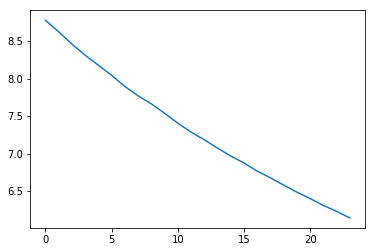

In [41]:
plt.plot((n_z_theory[1,:]/n_z_theory1[1,:])[:-1])

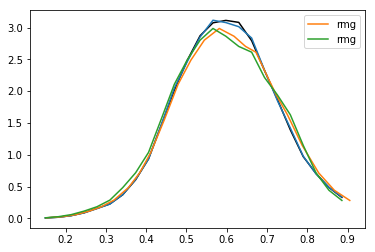

In [182]:
i=1

plt.plot(z_ref[:-2],nzs_wl_20[i][:-1]/np.trapz(nzs_wl_20[i][:-1],z_ref[:-2]),color='black')
plt.plot(z_ref[:-2],n_z_theory1[i,:-1]/auto_theory1[i,:-1]/np.trapz(n_z_theory1[i,:-1]/auto_theory1[i,:-1],z_ref[:-2],))
plt.plot(z_ref[:-2]+rmg_shift[:-1],rn_z_theory1[i,:-1]/auto_theory1[i,:-1]/np.trapz(n_z_theory1[i,:-1]/auto_theory1[i,:-1],z_ref[:-2]),label='rmg')
plt.plot(z_ref[:-2],rn_z_theory1[i,:-1]/auto_theory1[i,:-1]/np.trapz(n_z_theory1[i,:-1]/auto_theory1[i,:-1],z_ref[:-2]),label='rmg')

plt.legend()



# setup eBoss

In [43]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import h5py 
def convert_to_pix_coord(ra, dec, nside=1024,nest=False):
    """
    Converts RA,DEC to hpix coordinates
    """

    theta = (90.0 - dec) * np.pi / 180.
    phi = ra * np.pi / 180.
    pix = hp.ang2pix(nside, theta, phi, nest=nest)

    return pix

def IndexToDeclRa(index, nside=1024,nest= False):
    theta,phi=hp.pixelfunc.pix2ang(nside ,index,nest=nest)
    return -np.degrees(theta-np.pi/2.),np.degrees(phi)

def generate_randoms_radec(minra, maxra, mindec, maxdec, Ngen, raoffset=0):
    r = 1.0
    # this z is not redshift!
    zmin = r * np.sin(np.pi * mindec / 180.)
    zmax = r * np.sin(np.pi * maxdec / 180.)
   
    # parity transform from usual, but let's not worry about that
    phimin = np.pi / 180. * (minra - 180 + raoffset)
    phimax = np.pi / 180. * (maxra - 180 + raoffset)
   
    # generate ra and dec
    z_coord = np.random.uniform(zmin, zmax, Ngen)  # not redshift!
    phi = np.random.uniform(phimin, phimax, Ngen)
    dec_rad = np.arcsin(z_coord / r)
   
    # convert to ra and dec
    ra = phi * 180 / np.pi + 180 - raoffset
    dec = dec_rad * 180 / np.pi
    return ra, dec



import pyfits as pf
import numpy as np
mute = pf.open("/global/cscratch1/sd/mgatti/clustering_z/eBOSS_BOSS_all5_v5-6july19_y3cuts_totweight.fits")

nside = 1024
pix_mask = convert_to_pix_coord(mute[1].data['ra'],mute[1].data['dec'], nside=1024,nest=False)



# select Buzzard with a given redshift distribution!

# add cuts **************
mastercat = h5py.File('/global/cscratch1/sd/jderose/BCC/Chinchilla/Herd/Chinchilla-3/sampleselection/Y3a/Buzzard-3_v1.9.8_Y3a_mastercat.h5')

zb = np.array(mastercat['catalog']['bpz'][u'unsheared']['z'])[mastercat['index']['maglim']['select']]
rab = np.array(mastercat['catalog']['gold'][u'ra'])[mastercat['index']['maglim']['select']]
decb = np.array(mastercat['catalog']['gold'][u'dec'])[mastercat['index']['maglim']['select']]


pix_buzz = convert_to_pix_coord(rab,decb, nside=1024,nest=False)

mask = np.in1d(pix_buzz,pix_mask)
ra_buzz = rab[mask]
dec_buzz = decb[mask]
z_buzz = zb[mask]



# random draw from a distribution ****************
hx,be=np.histogram(mute[1].data['z'], bins = np.linspace(0.1,1.1,50),normed=True)

hz,_ = np.histogram(z_buzz, bins = np.linspace(0.1,1.1,50),normed=True)
w = ((hx/hz)/np.sum((hx/hz))*len(mute[1].data['z'])/np.sum((hx/hz)/np.sum((hx/hz)))).astype(int)
wh = ((z_buzz -0.1)/(be[1]-be[0])).astype(int)
new_z = []
new_ra = []
new_dec = []
idd = np.random.randint(0,len(z_buzz),len(mute[1].data['z']))
new_z = z_buzz[idd]
new_ra = ra_buzz[idd]
new_dec = dec_buzz[idd]
"""
for wx in range(50-1):
    #try:
        maski = wh==wx
        index = np.random.randint(0,len(z_buzz[maski]),w[wx])
        new_z=np.hstack([new_z,np.array(z_buzz[maski][index])])
        new_ra=np.hstack([new_ra,np.array(ra_buzz[maski][index])])
        new_dec=np.hstack([new_dec,np.array(dec_buzz[maski][index])]) 
#plt.scatter()
"""
# create randoms *****************
ra_rndm = np.array(mastercat['randoms']['maglim']['ra'])
dec_rndm = np.array(mastercat['randoms']['maglim']['dec'])

pix_buzz = convert_to_pix_coord(ra_rndm,dec_rndm, nside=1024,nest=False)

mask = np.in1d(pix_buzz,pix_mask)
ra_rndm = ra_rndm[mask]
dec_rndm = dec_rndm[mask]

print ("done")
# *********************************************


from astropy.table import Table
import os
folder = "/global/cscratch1/sd/mgatti/clustering_z/data/"
path = folder + 'eboss_buzzard.fits'
try:
    os.remove(path)
except:
    pass
idd = np.random.randint(0,len(new_ra),300000)
fits_f = Table()
fits_f['ra'] = new_ra[idd]
fits_f['dec'] = new_dec[idd]
fits_f['e1'] = np.ones(len(new_ra[idd]))
fits_f['e2'] = np.ones(len(new_ra[idd]))
fits_f['z'] = new_z[idd]
fits_f['tomo_bin'] = np.ones(len(new_ra[idd]))

fits_f.write(path)


folder = "/global/cscratch1/sd/mgatti/clustering_z/data/"
path = folder + 'eboss_randoms_buzzard.fits'
try:
    os.remove(path)
except:
    pass
fits_f = Table()
fits_f['ra'] =ra_rndm
fits_f['dec'] = dec_rndm

fits_f.write(path)

mastercat = h5py.File('/global/homes/j/jderose/cscratch/BCC/Chinchilla/Herd/Chinchilla-3/sampleselection/Y3a/Buzzard-3_v1.9.8_Y3a_mastercat.h5')
decrm = np.array(mastercat['catalog'][ 'redmagic']['combined_sample_fid']['dec'])
rarm = np.array(mastercat['catalog'][ 'redmagic']['combined_sample_fid']['ra'])
zspecrm = np.array(mastercat['catalog'][ 'redmagic']['combined_sample_fid']['zspec'])
zredmagic =np.array( mastercat['catalog'][ 'redmagic']['combined_sample_fid']['zredmagic'])
weight = np.array(mastercat['catalog'][ 'redmagic']['combined_sample_fid']['weights'])
id_obj = np.array(mastercat['catalog'][ 'redmagic']['combined_sample_fid']['coadd_object_id'])

pix_buzz = convert_to_pix_coord(rarm,decrm, nside=1024,nest=False)
mask = np.in1d(pix_buzz,pix_mask)
from astropy.table import Table
path = folder + '/redMagic_Y3_eboss.fits'
try:
    os.remove(path)
except:
    pass
fits_f = Table()
fits_f['RA'] = rarm[mask]
fits_f['DEC'] = decrm[mask]
fits_f['ZREDMAGIC'] = zredmagic[mask]
fits_f['Z'] = zspecrm[mask]
fits_f['weight'] = weight[mask]
fits_f.write(path)





ra_rm_rand = np.array(mastercat['randoms']['redmagic']['combined_sample_fid']['ra'])
dec_rm_rand = np.array(mastercat['randoms']['redmagic']['combined_sample_fid']['dec'])

pix_buzz = convert_to_pix_coord(ra_rm_rand,dec_rm_rand, nside=1024,nest=False)
mask = np.in1d(pix_buzz,pix_mask)
from astropy.table import Table
path = folder + '/redMagic_Y3_randoms_eboss.fits'
try:
    os.remove(path)
except:
    pass
fits_f = Table()
fits_f['RA'] = ra_rm_rand[mask]
fits_f['DEC'] = dec_rm_rand[mask]
fits_f.write(path)

mastercat.close()


done


IOError: File exists: /global/cscratch1/sd/mgatti/clustering_z/data//redMagic_Y3_eboss.fits

In [15]:
wide = pf.open('/global/cscratch1/sd/giannini/clusteringz/wide.fits')
e1_sh = wide[1].data['e1']
e2_sh = wide[1].data['e2']
id_obj_sh =  wide[1].data['COADD_OBJECT_ID']#[mask_wl]                                                                                   
ra_sh = wide[1].data['ra']#[#mask_wl]                                                                                                     
dec_sh = wide[1].data['dec']#[mask_wl]                                                                                                    
flux_i_sh = wide[1].data['FLUX_I']
tomo_bin = wide[1].data['tomo_bin_wide']
z_sh = wide[1].data['Z']
hpix_sh = wide[1].data['HPIX_16384']

e1_sh = e1_sh.byteswap().newbyteorder()
e2_sh = e2_sh.byteswap().newbyteorder()
id_obj_sh = id_obj_sh.byteswap().newbyteorder()
ra_sh = ra_sh.byteswap().newbyteorder()
dec_sh = dec_sh.byteswap().newbyteorder()
flux_i_sh = flux_i_sh.byteswap().newbyteorder()
tomo_bin = tomo_bin.byteswap().newbyteorder()
z_sh = z_sh.byteswap().newbyteorder()
hpix_sh = hpix_sh.byteswap().newbyteorder()

import pandas as pf

e1_sh = pd.DataFrame(e1_sh)
e2_sh = pd.DataFrame(e2_sh)
id_obj_sh =  pd.DataFrame(id_obj_sh)                                                                          
ra_sh = pd.DataFrame(ra_sh)
dec_sh = pd.DataFrame(dec_sh)
flux_i_sh = pd.DataFrame(flux_i_sh)
tomo_bin = pd.DataFrame(tomo_bin)
z_sh = pd.DataFrame(z_sh)
hpix_sh = pd.DataFrame(hpix_sh)

pix_sample = convert_to_pix_coord(ra_sh, dec_sh,nside)
#mask_redmagic = load...
#mask_rm = np.in1d(shape_pix, hpix)
mask_rm = np.in1d(pix_sample,pix_mask)
#new_ra = ra[new_mask]
from astropy.table import Table

for i in range(4):
    mask1 = tomo_bin[mask_rm] ==i
    folder = "/global/cscratch1/sd/mgatti/clustering_z/data/"
    path = folder + 'eboss_WL_buzzard_{0}.fits'.format(i)
    try:
        os.remove(path)
    except:
        pass
    fits_f = Table()
    fits_f['ra'] = ra_sh[mask_rm][mask1]
    fits_f['dec'] = dec_sh[mask_rm][mask1]
    fits_f['e1'] = e1_sh[mask_rm][mask1]
    fits_f['e2'] = e2_sh[mask_rm][mask1]
    fits_f['z'] = z_sh[mask_rm][mask1]
    fits_f['tomo_bin'] = tomo_bin[mask_rm][mask1]
    fits_f['id_obj'] = id_obj_sh[mask_rm][mask1]
    fits_f['flux_i'] = flux_i_sh[mask_rm][mask1]
    fits_f.write(path)


folder = "/global/cscratch1/sd/mgatti/clustering_z/data/"
path = folder + 'eboss_WL_buzzard.fits'
try:
    os.remove(path)
except:
    pass
fits_f = Table()
fits_f['ra'] = ra_sh[mask_rm]
fits_f['dec'] = dec_sh[mask_rm]
fits_f['e1'] = e1_sh[mask_rm]
fits_f['e2'] = e2_sh[mask_rm]
fits_f['z'] = z_sh[mask_rm]
fits_f['tomo_bin'] = tomo_bin[mask_rm]
fits_f['id_obj'] = id_obj_sh[mask_rm]
fits_f['flux_i'] = flux_i_sh[mask_rm]
fits_f.write(path)


'\nfolder = "/global/cscratch1/sd/mgatti/clustering_z/data/"\npath = folder + \'eboss_WL_buzzard.fits\'\nfits_f = Table()\nfits_f[\'ra\'] = ra_sh[mask_rm]\nfits_f[\'dec\'] = dec_sh[mask_rm]\nfits_f[\'e1\'] = e1_sh[mask_rm]\nfits_f[\'e2\'] = e2_sh[mask_rm]\nfits_f[\'z\'] = z_sh[mask_rm]\nfits_f[\'tomo_bin\'] = tomo_bin[mask_rm]\nfits_f[\'id_obj\'] = id_obj_sh[mask_rm]\nfits_f[\'flux_i\'] = flux_i_sh[mask_rm]\nfits_f.write(path)\n'

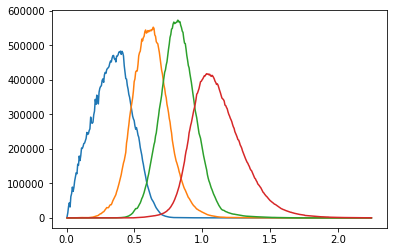

IndexError: list index out of range

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
# CREATE FILES FOR COSMOSIS (TO CREATE THEORY W_DM!)

import h5py
import pyfits as pf

mastercat = h5py.File('/global/cscratch1/sd/jderose/BCC/Chinchilla/Herd/Chinchilla-3/sampleselection/Y3a/Buzzard-3_v1.9.8_Y3a_mastercat.h5')
zredmagic_tot = mastercat['catalog']['redmagic']['combined_sample_fid']['zredmagic']
zspec_tot = mastercat['catalog']['redmagic']['combined_sample_fid']['zspec']
mastercat.close()
mute = pf.open("/global/cscratch1/sd/jmyles/sompz_buzzard/v0.11/2019-10-16/wide.fits")
meanz_pz = mute[1].data["tomo_bin_wide"]
redshift_pz = mute[1].data["z"]

import twopoint


# bin the sources (4 bins) and lenses (10, 20 bins)
zmin=0.1
zmax=1.1
bins = 15

z_ref = np.linspace(zmin,zmax,bins+1)
binx = [-0.5,0.5,1.5,2.5,3.5]
hrn = 401
bins_hr = np.linspace(0.,2.25,hrn)


nzs_wl=[]
nzs_wl_20 =[]
for i in range(4):
    mask_z = (meanz_pz>binx[i]) & (meanz_pz<binx[i+1] )
    nzrm,edge = np.histogram(redshift_pz[mask_z], bins = bins_hr)
    
    zlow_wl = edge[:-1]
    zhigh_wl = edge[1:]
    z_wl = (edge[:-1]+edge[1:])/2.
    plt.plot(z_wl,nzrm)
    nzs_wl.append(nzrm)
    
    nzrm1,edge = np.histogram(redshift_pz[mask_z], bins = z_ref)
    nzs_wl_20.append(nzrm1)
plt.show()
nzs_wl.append(np.ones(len(nzrm1)))
name = "nz_source"
nz_wl  = twopoint.NumberDensity(name, zlow_wl, z_wl, zhigh_wl, nzs_wl)


binx =  np.linspace(zmin,zmax,bins+1)


nzs_20=[]
for i in range(bins):
    mask_z = (new_z>binx[i]) & (new_z<binx[i+1] )
    nzrm,edge = np.histogram(new_z[mask_z], bins = bins_hr)

    zlow_20 = edge[:-1]
    zhigh_20 = edge[1:]
    z_20 = (edge[:-1]+edge[1:])/2.
    nzs_20.append(nzrm)
name = "nz_lens"
nz_lenses  = twopoint.NumberDensity(name, zlow_20, z_20, zhigh_20, nzs_20)



from routines import *
  

try:
    os.remove("./cosmosis/run_cosmosis_20_eboss.fits")
except:
    pass
obj1,a,_ = make_fits(runs[0]['Nz'],runs[0]['qz'],runs[0]['bz'],nz_wl,nz_lenses)
obj1.to_fits("./cosmosis/run_cosmosis_20_eboss.fits")


print "done"

In [15]:
import cosmolopy.distance as cd
import cosmolopy
from scipy.interpolate import interp1d
from scipy.integrate import quad
import math




min_rp  = 500
max_rp = 1500
bins_ref = bins 
angular_bins = 8
om = 0.286
s8 = 0.82

cosmo = {'omega_M_0':om, 
         'omega_lambda_0':1-om,
         'omega_k_0': 0.0, 
         'omega_b_0' : 0.048,
         'h':0.69,
         'sigma_8' : s8,
         'n': 0.96}


folder = "/global/homes/m/mgatti/clustering-z/cosmosis/out_20_eboss/"
foldermm = "/global/homes/m/mgatti/clustering-z/cosmosis/out_20_mm/"

z_ref = np.linspace(zmin,zmax,bins+1)
n_z_theory = np.zeros((4,bins_ref))
n_z_theory1 = np.zeros((4,bins_ref))
n_z_theory_b = np.zeros((4,bins_ref))

auto_theory = np.zeros((4,bins_ref))
auto_theory1 = np.zeros((4,bins_ref))
auto_theory_arr = np.zeros((4,angular_bins,bins_ref))
n_z_theory_arr = np.zeros((4,angular_bins,bins_ref))
auto_theory_arr1 = np.zeros((4,angular_bins,bins_ref))

mag_mag = np.zeros((4,bins_ref))
mag_pos = np.zeros((4,bins_ref))
mag_pos1 = np.zeros((4,bins_ref))
mag_shear = np.zeros((4,bins_ref))
mag_shear1 = np.zeros((4,bins_ref))

mag_rm = np.zeros((bins_ref,bins_ref))
mag_rm1 = np.zeros((bins_ref,bins_ref))
auto_mm = np.zeros((bins_ref,bins_ref))
auto_ref_const = np.zeros((4,bins_ref))
for j in range(4):
    for i in range(bins_ref):
        dz =0.5*( z_ref[1]-z_ref[0])
        
        theta_out = runs[0]['theta_arr'][j,:,i]
        # *****  mag mag  *************
        mute = np.loadtxt(folder+"/mag_mag_xi_2/bin_{0}_{1}.txt".format(i+1,j+1))
        theta = np.loadtxt(folder+"/mag_mag_xi_2/theta.txt")/((2*math.pi)/360)
        min_theta_rp=(min_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        max_theta_rp=(max_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        f = interp1d(theta,mute/theta**gamma)
        mag_mag[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]  
        
        
        
        # *****  mag pos  *************
        mute = np.loadtxt(folder+"/mag_pos_xi/bin_{1}_{0}.txt".format(i+1,j+1))
        theta = np.loadtxt(folder+"/mag_pos_xi/theta.txt")/((2*math.pi)/360)
        min_theta_rp=(min_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        max_theta_rp=(max_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        f = interp1d(theta,mute/theta**gamma)
        mag_pos[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]  
        
        
        # *****  mag pos  *************
        mute = np.loadtxt(folder+"/mag_pos_xi_2/bin_{0}_{1}.txt".format(i+1,j+1))
        theta = np.loadtxt(folder+"/mag_pos_xi_2/theta.txt")/((2*math.pi)/360)
        min_theta_rp=(min_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        max_theta_rp=(max_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        f = interp1d(theta,mute/theta**gamma)
        mag_pos1[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]  
        
        
        
        # *****  mag shear  *************
        mute = np.loadtxt(folder+"/mag_shear_xi/bin_{0}_{1}.txt".format(i+1,j+1))

        f = interp1d(theta,mute/theta**gamma)
        mag_shear[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]
        mag_shear1[j,i] = quad(f,theta_out[0],theta_out[-1])[0]
        
        # ****** NZ *******************
        mute = np.loadtxt(folder+"/galaxy_xi/bin_{0}_{1}.txt".format(i+1,j+1))
        f = interp1d(theta,mute/theta**gamma)
        n_z_theory[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]
        n_z_theory1[j,i] = quad(f,theta_out[0],theta_out[-1])[0]
        f = interp1d(theta,mute)
        n_z_theory_arr[j,:,i] = f(theta_out)
        
        # ****** AUTO_CONST *******************
        mute = np.loadtxt(folder+"/galaxy_xi/bin_{0}_{1}.txt".format(5,j+1))
        f = interp1d(theta,mute/theta**gamma)
        auto_ref_const[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]
        
        
        mute = np.loadtxt(folder+"/matter_auto_xi/bin_{0}_{1}.txt".format(i+1,i+1))
        f = interp1d(theta,mute/theta**gamma)
        auto_theory[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]
        f = interp1d(theta,mute/theta**gamma)
        auto_theory1[j,i] = quad(f,theta_out[0],theta_out[-1])[0]
        f = interp1d(theta,mute)
        auto_theory_arr[j,:,i] = f(theta_out)
        n_z_theory_b[j,i] = n_z_theory[j,i]/auto_theory[j,i]
        #n_z_theory_b[j,i] = n_z_theory[j,i]/auto_ref_const[j,i]
        

        
print "done"












folder = "/global/homes/m/mgatti/clustering-z/cosmosis/out_20_rmg/"
foldermm = "/global/homes/m/mgatti/clustering-z/cosmosis/out_20_mm/"

z_ref = np.linspace(zmin,zmax,bins+1)
rn_z_theory = np.zeros((4,bins_ref))
rn_z_theory1 = np.zeros((4,bins_ref))
rn_z_theory_b = np.zeros((4,bins_ref))

rauto_theory = np.zeros((4,bins_ref))
rauto_theory1 = np.zeros((4,bins_ref))
rauto_theory_arr = np.zeros((4,angular_bins,bins_ref))
rn_z_theory_arr = np.zeros((4,angular_bins,bins_ref))
rauto_theory_arr1 = np.zeros((4,angular_bins,bins_ref))

rmag_mag = np.zeros((4,bins_ref))
rmag_pos = np.zeros((4,bins_ref))
rmag_pos1 = np.zeros((4,bins_ref))
rmag_shear = np.zeros((4,bins_ref))
rmag_shear1 = np.zeros((4,bins_ref))

rmag_rm = np.zeros((bins_ref,bins_ref))
rmag_rm1 = np.zeros((bins_ref,bins_ref))
rauto_mm = np.zeros((bins_ref,bins_ref))
rauto_ref_const = np.zeros((4,bins_ref))
for j in range(4):
    for i in range(bins_ref):
        dz =0.5*( z_ref[1]-z_ref[0])
        
        theta_out = runs[0]['theta_arr'][j,:,i]
        # *****  mag mag  *************
        mute = np.loadtxt(folder+"/mag_mag_xi_2/bin_{0}_{1}.txt".format(i+1,j+1))
        theta = np.loadtxt(folder+"/mag_mag_xi_2/theta.txt")/((2*math.pi)/360)
        min_theta_rp=(min_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        max_theta_rp=(max_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        f = interp1d(theta,mute/theta**gamma)
        rmag_mag[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]  
        
        
        
        # *****  mag pos  *************
        mute = np.loadtxt(folder+"/mag_pos_xi/bin_{1}_{0}.txt".format(i+1,j+1))
        theta = np.loadtxt(folder+"/mag_pos_xi/theta.txt")/((2*math.pi)/360)
        min_theta_rp=(min_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        max_theta_rp=(max_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        f = interp1d(theta,mute/theta**gamma)
        rmag_pos[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]  
        
        
        # *****  mag pos  *************
        mute = np.loadtxt(folder+"/mag_pos_xi_2/bin_{0}_{1}.txt".format(i+1,j+1))
        theta = np.loadtxt(folder+"/mag_pos_xi_2/theta.txt")/((2*math.pi)/360)
        min_theta_rp=(min_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        max_theta_rp=(max_rp/(1000*(1.+z_ref[i]+dz)*cd.angular_diameter_distance(z_ref[i]+dz,**cosmo)))/((2*math.pi)/360)
        f = interp1d(theta,mute/theta**gamma)
        rmag_pos1[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]  
        
        
        
        # *****  mag shear  *************
        mute = np.loadtxt(folder+"/mag_shear_xi/bin_{0}_{1}.txt".format(i+1,j+1))

        f = interp1d(theta,mute/theta**gamma)
        rmag_shear[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]
        rmag_shear1[j,i] = quad(f,theta_out[0],theta_out[-1])[0]
        
        # ****** NZ *******************
        mute = np.loadtxt(folder+"/galaxy_xi/bin_{0}_{1}.txt".format(i+1,j+1))
        f = interp1d(theta,mute/theta**gamma)
        rn_z_theory[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]
        rn_z_theory1[j,i] = quad(f,theta_out[0],theta_out[-1])[0]
        f = interp1d(theta,mute)
        rn_z_theory_arr[j,:,i] = f(theta_out)
        
        # ****** AUTO_CONST *******************
        mute = np.loadtxt(folder+"/galaxy_xi/bin_{0}_{1}.txt".format(5,j+1))
        f = interp1d(theta,mute/theta**gamma)
        rauto_ref_const[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]
        
        
        mute = np.loadtxt(folder+"/matter_auto_xi/bin_{0}_{1}.txt".format(i+1,i+1))
        f = interp1d(theta,mute/theta**gamma)
        rauto_theory[j,i] = quad(f,min_theta_rp,max_theta_rp)[0]
        f = interp1d(theta,mute/theta**gamma)
        rauto_theory1[j,i] = quad(f,theta_out[0],theta_out[-1])[0]
        f = interp1d(theta,mute)
        rauto_theory_arr[j,:,i] = f(theta_out)
        rn_z_theory_b[j,i] = n_z_theory[j,i]/auto_theory[j,i]
        #n_z_theory_b[j,i] = n_z_theory[j,i]/auto_ref_const[j,i]
        

        
print "done"


/global/homes/m/mgatti/.conda/envs/myenv/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/global/homes/m/mgatti/.conda/envs/myenv/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


done
done


In [7]:
save_all=load_obj("info_wz_eboss")
save_all["b_wl"]  = b_wl
save_obj("info_wz_eboss",save_all)

In [6]:
import pyfits as pf
nz_true = pf.open("./cosmosis/run_cosmosis_20_eboss.fits")
nz_rmg = pf.open("./cosmosis/run_cosmosis_20_rmg.fits")

save_all = dict()
save_all["n_jck"] = n_jck
save_all["runs"]=runs
save_all["b_wl"]  = b_wl

save_all["nz_true"]=nz_true
save_all["nz_rmg"] = nz_rmg

save_all["angular_bins"]=angular_bins
save_all["bins_ref"] = bins_ref


save_all["nz_theory"] =n_z_theory1
save_all["rnz_theory"] =rn_z_theory1
save_all["auto_theory"] = auto_theory1
save_all["auto_theory_jk"] = auto_theory_jk

save_all["rauto_theory"] = rauto_theory1

save_all["auto_theory_arr"] = auto_theory_arr
save_all["rauto_theory_arr"] = rauto_theory_arr

save_all["mag_pos"] = mag_pos
save_all["mag_pos1"] = mag_pos1

save_all["rmag_pos"] = rmag_pos
save_all["rmag_pos1"] = rmag_pos1

 #true z distr in sims
save_all["true_binned"] = nzs_wl_20
save_all["rmg_shift"]= 0.

info = {'z_ref_edges':z_ref,
        'z_ref' : (z_ref[:-1]+z_ref[1:])/2.,
       'z_min':zmin,
       'z_max':zmax,
        'bins_ref':bins_ref
       }
save_all['info']=info
save_obj("info_wz_eboss",save_all)

NameError: name 'angular_bins' is not defined

(array([  5341.,   7792.,   9335.,  12999.,  13454.,  24570.,  24447.,
         22014.,  25029.,  36737.,  31758.,  19253.,  12086.,   7344.]),
 array([ 0.1       ,  0.17142857,  0.24285714,  0.31428571,  0.38571429,
         0.45714286,  0.52857143,  0.6       ,  0.67142857,  0.74285714,
         0.81428571,  0.88571429,  0.95714286,  1.02857143,  1.1       ]),
 <a list of 1 Patch objects>)

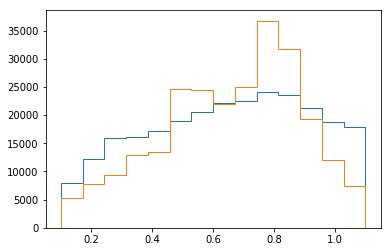

In [35]:
#plt.hist(new_z ,histtype='step',bins=np.linspace(0.1,1.1,15))
plt.hist(mute[1].data['z'] ,histtype='step',bins=np.linspace(0.1,1.1,15))
plt.xlabel("z",)

In [25]:
mastercat_data['catalog']['redmagic']['combined_sample_fid'].keys()

[u'chisq',
 u'coadd_object_id',
 u'dec',
 u'lum',
 u'mag',
 u'mag_err',
 u'ra',
 u'refmag',
 u'refmag_err',
 u'weight',
 u'zredmagic',
 u'zredmagic_e',
 u'zredmagic_samp',
 u'zspec']